# Inventory Dynamics


<a id='index-0'></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit, jitclass, float64, prange

In [2]:
firm_data = [
   ('s', float64),          # restock trigger level
   ('S', float64),          # capacity
   ('mu', float64),         # shock location parameter
   ('sigma', float64)       # shock scale parameter
]


@jitclass(firm_data)
class Firm:

    def __init__(self, s=10, S=100, mu=1.0, sigma=0.5):

        self.s, self.S, self.mu, self.sigma = s, S, mu, sigma

    def update(self, x):
        "Update the state from t to t+1 given current state x."

        Z = np.random.randn()
        D = np.exp(self.mu + self.sigma * Z)
        if x <= self.s:
            return max(self.S - D, 0)
        else:
            return max(x - D, 0)

    def sim_inventory_path(self, x_init, sim_length):

        X = np.empty(sim_length)
        X[0] = x_init

        for t in range(sim_length-1):
            X[t+1] = self.update(X[t])
        return X

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  if __name__ == '__main__':


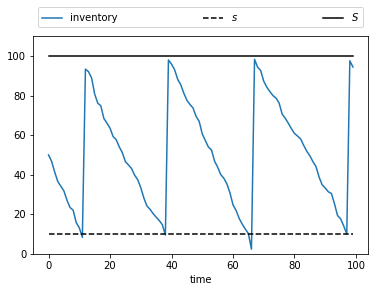

In [3]:
firm = Firm()

s, S = firm.s, firm.S
sim_length = 100
x_init = 50

X = firm.sim_inventory_path(x_init, sim_length)

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(s * np.ones(sim_length), 'k--', label="$s$")
ax.plot(S * np.ones(sim_length), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

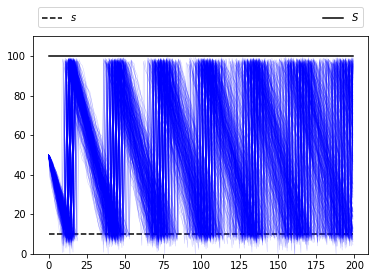

In [4]:
sim_length=200
fig, ax = plt.subplots()

ax.plot(s * np.ones(sim_length), 'k--', label="$s$")
ax.plot(S * np.ones(sim_length), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.legend(**legend_args)

for i in range(400):
    X = firm.sim_inventory_path(x_init, sim_length)
    ax.plot(X, 'b', alpha=0.2, lw=0.5)

plt.show()

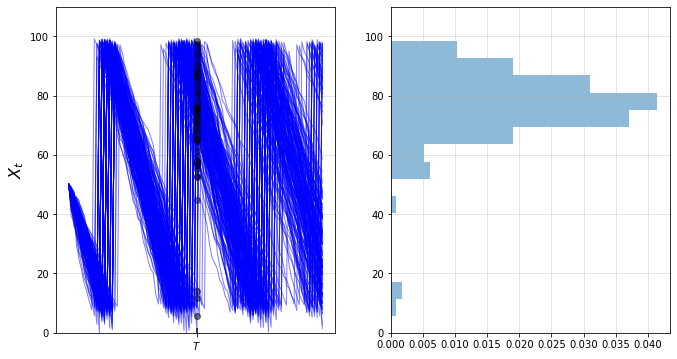

In [5]:
T = 50
M = 200  # Number of draws

ymin, ymax = 0, S + 10

fig, axes = plt.subplots(1, 2, figsize=(11, 6))

for ax in axes:
    ax.grid(alpha=0.4)

ax = axes[0]

ax.set_ylim(ymin, ymax)
ax.set_ylabel('$X_t$', fontsize=16)
ax.vlines((T,), -1.5, 1.5)

ax.set_xticks((T,))
ax.set_xticklabels((r'$T$',))

sample = np.empty(M)
for m in range(M):
    X = firm.sim_inventory_path(x_init, 2 * T)
    ax.plot(X, 'b-', lw=1, alpha=0.5)
    ax.plot((T,), (X[T+1],), 'ko', alpha=0.5)
    sample[m] = X[T+1]

axes[1].set_ylim(ymin, ymax)

axes[1].hist(sample,
             bins=16,
             density=True,
             orientation='horizontal',
             histtype='bar',
             alpha=0.5)

plt.show()

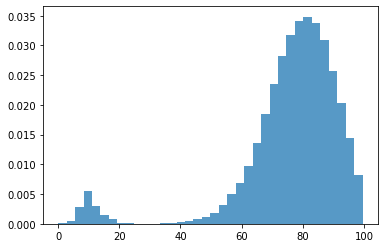

In [6]:
T = 50
M = 50_000

fig, ax = plt.subplots()

sample = np.empty(M)
for m in range(M):
    X = firm.sim_inventory_path(x_init, T+1)
    sample[m] = X[T]

ax.hist(sample,
         bins=36,
         density=True,
         histtype='bar',
         alpha=0.75)

plt.show()

In [7]:
from sklearn.neighbors import KernelDensity

def plot_kde(sample, ax, label=''):

    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

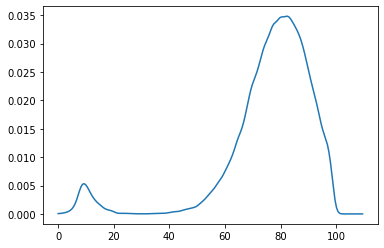

In [8]:
fig, ax = plt.subplots()
plot_kde(sample, ax)
plt.show()

In [9]:
s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma

@njit(parallel=True)
def shift_firms_forward(current_inventory_levels, num_periods):

    num_firms = len(current_inventory_levels)
    new_inventory_levels = np.empty(num_firms)

    for f in prange(num_firms):
        x = current_inventory_levels[f]
        for t in range(num_periods):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
            else:
                x = max(x - D, 0)
        new_inventory_levels[f] = x

    return new_inventory_levels

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


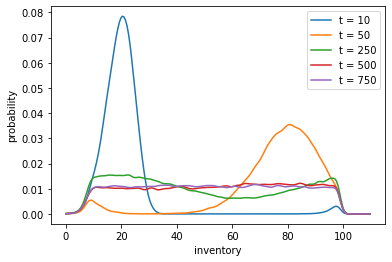

In [10]:
x_init = 50
num_firms = 50_000

sample_dates = 0, 10, 50, 250, 500, 750

first_diffs = np.diff(sample_dates)

fig, ax = plt.subplots()

X = np.ones(num_firms) * x_init

current_date = 0
for d in first_diffs:
    X = shift_firms_forward(X, d)
    current_date += d
    plot_kde(X, ax, label=f't = {current_date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

In [11]:
@njit(parallel=True)
def compute_freq(sim_length=50, x_init=70, num_firms=1_000_000):

    firm_counter = 0  # Records number of firms that restock 2x or more
    for m in prange(num_firms):
        x = x_init
        restock_counter = 0  # Will record number of restocks for firm m

        for t in range(sim_length):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
                restock_counter += 1
            else:
                x = max(x - D, 0)

        if restock_counter > 1:
            firm_counter += 1

    return firm_counter / num_firms

In [12]:
%%time

freq = compute_freq()
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.447216
Wall time: 1.12 s
